# Bayesian Crowd Counting

In this example we will use a Machine Learning model to count the number of people in an image. 


# Hardware Setup
----
### 1. KRIA KV260 Board<br> 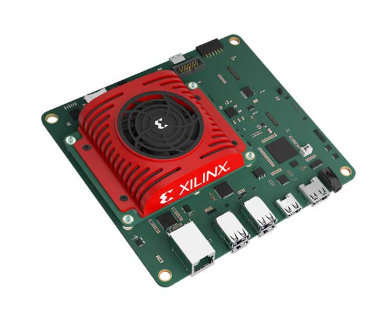
### 2. PYNQ Grove Adapter<br> 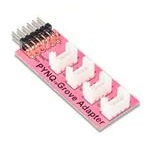
### 3. LED Bar<br> 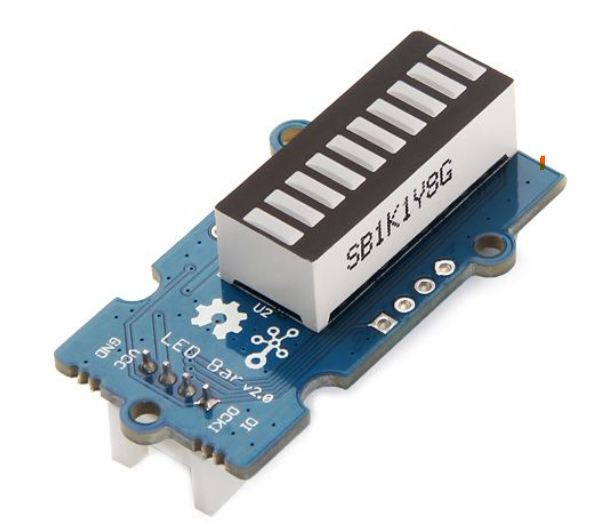
### 4. Webcam<br>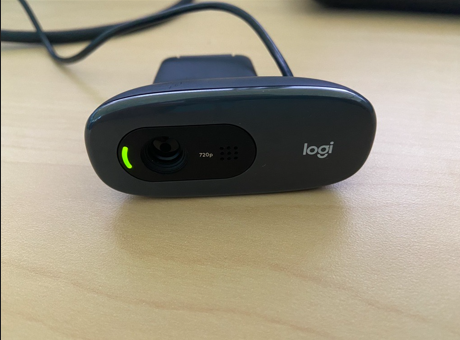

# Let's get started 
----

## Imports

These are all of the imports that we will need to use the Crowd Estimation model and analyze its data.

In [1]:
import os    # used to execute bash commands to download and uncompress stuff
import cv2   # OpenCV image processing library
import glob

from PIL import Image

import numpy as np  # For math
import matplotlib.pyplot as plt  # For plotting stuff
from pynq_dpu import DpuOverlay   # Overlay for the FPGA
from pynq_peripherals import PmodGroveAdapter



## FPGA Overlays

FPGAs are specialized hardware that can reconfigure their internal architecture to suit the needs of the application.


In [2]:

# set hardware config on the board
overlay = DpuOverlay("dpu.bit")


Make sure your led bar is plugged into the G2 slot of the PYNQ Grove Adapter.

In [3]:
# setup led bar on the board 
adapter = PmodGroveAdapter(overlay.PMODA, G2='grove_ledbar')
ledbar = adapter.G2


## AI Model

In this tutorial we will be using the Bayesian crowd counting (BCC) model which is a Deep Learning model for crowd detection. 

**Goal**: To detect the number of people in the image of a crowded environment

**Input**: An Image of size 1000 x 800 pixels (preprocessed)

**Output**: A Tensor (matrix) of the number of people for some "key" points in the images. To get final count sum of all the values.

The model is trained on the ShanghaiTechA Dataset which contains images of crowded environments and the "correct" count of people in that image.

It is based on the Resnet model which is a CNN model.

In [4]:

# load the model on the board
overlay.load_model("data/pt_BCC.xmodel")


## Load an Image

To test the model, let's load an image of a crowd and see if the model can accurately calculate the number of people in it.


In [5]:

# find all images in the directory
image_path_list = glob.glob("data/*.jpg")

# list all the found images
for img_path in image_path_list:
    print(img_path)

# select index of one of the image
img_indx = 1

# load that image
img_pil = Image.open(image_path_list[img_indx]).convert('RGB')

# convert the loaded image into numpy array
img_np = np.array(img_pil)



data/test_image3.jpg
data/test_image4.jpg
data/test_image2.jpg
data/test_image5.jpg
data/test_image1.jpg


Let's display our image.

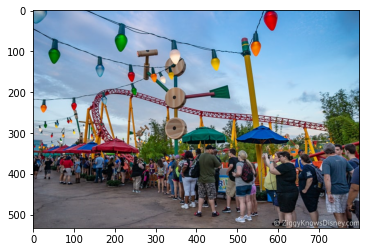

In [6]:

plt.imshow(img_np)


## Get width, height, channel of an image

In [7]:

img_h, img_w, img_c = img_np.shape
print(img_np.shape)


(533, 800, 3)


## How an image is stored in computers.
A 3D tensor (generalization of matrix)

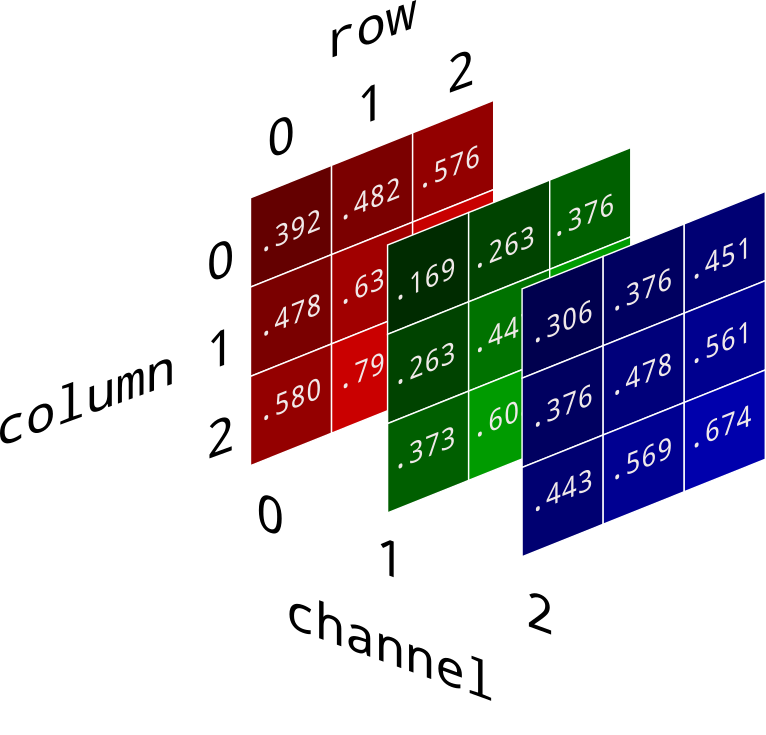


## A function to Preprocess the image

Takes in an RGB image and outputs normalized image. This makes the image the correct size to input into our model.


In [8]:

def preprocess(img):
    img = Image.fromarray(img.astype('uint8'), 'RGB')#  convert to pil image
    img = img.resize((1000, 800)) # resize to 1000 x 800 image
    img = 1.0 * np.array(img) / 255 # normalize to 0, 1
    
    img -= np.array([0.485, 0.456, 0.406]) 
    img /= np.array([0.229, 0.224, 0.225]) # z score normalization (calculated from training dataset)
        
    return img.astype(np.float32, order="C") # order "C" switchs rows and columns
    

Now, let's call the above function passing in the image that we want processed. You will see that the image shape will be the correct size that the model requires.

In [9]:

input_img = preprocess(img_np)
print(input_img.shape)


(800, 1000, 3)


## Execute Job on the DPU

Let's ensure that the input shapes that the DPU requires matches with our preprocessed image shape

In [10]:

# get a runner instance on the board
dpu = overlay.runner

# get shapes of input and output of model
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()
shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

shapeIn, shapeOut, outputSize 

((1, 800, 1000, 3), (1, 100, 126, 1), 12600)

Now, we add set the input data to equal the input img and tell the FPGA to run our model on the image. The program will wait to continue until the dpu has finished running the model.

In [11]:

# create place holders for input and output because the board is expecting a list of input NOT just 1 image
output_data = [np.zeros(shapeOut, dtype=np.float32, order="C")]
input_data = [np.zeros(shapeIn, dtype=np.float32, order="C")]

# set out image in input data placeholder
input_data[0] = input_img

# execute the job on board
job_id = dpu.execute_async(input_data, output_data)
dpu.wait(job_id)


0

The dpu has now set the output data equal to the array of "key points." Remember that the keypoints are where there is a person in the image. So, if we sum the number of "key points" in the output data, we will get the estimated number of people in the image.

In [12]:

# final count is the sum ouputs for all "key points"
final_count = np.sum(output_data[0]) 

print("The total number of people in the image are approximately: ", final_count)


The total number of people in the image are approximately:  40.3125


## Using the LED Bar



Finally, let's use a LED Bar to easily display a rough estimation of the number of people in an image. Let's say, for example, that the total number of people that our model estimated was 45.2125 people. We can multiply that number by 10 and then use the double divide to do integer division. That would be 452.125 // 100 = 4. Remember that integer division cuts off any decimal points. This gives us the number of bars to light up. Four bars lit up on the LED Bar means that approximately 40 people are in the image. Using the LED Bar help display the the number of people at the cost of accuracy.

In [15]:

MAX_NUM_PEOPLE = 100


brightness = 3  # brightness of led bars
green_to_red = 1

level = (10 * final_count) // MAX_NUM_PEOPLE # calculate level to set on ledbar
level = int(level) # requires integer


# if level is out of range (1 to 10) then set to minimum or maximum value
if(level <= 0):
    level = 1
elif(level > 10):
    level = 10

# set the level on the led bar
print("Setting LED level to:", level)
ledbar.set_level(int(level), brightness, green_to_red)



Setting LED level to: 4


The LED Bar should light up as in this picture

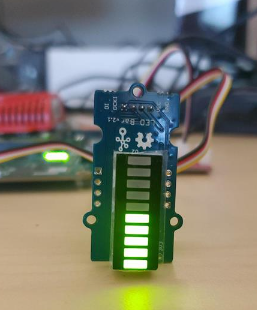

In [14]:

# clear ledbar
ledbar.clear()



## Bonus Quest

Get images from webcam input and pass them to the model.
 
Hint: refer to MNIST or YOLO notebooks.



